<h1>Содержание<span class="tocSkip"></span></h1>
<li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#DecisionTreeRegressor" data-toc-modified-id="DecisionTreeRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>DecisionTreeRegressor</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li><li><span><a href="#Catboost" data-toc-modified-id="Catboost-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Catboost</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#DecisionTreeRegressor" data-toc-modified-id="DecisionTreeRegressor-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>DecisionTreeRegressor</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li><li><span><a href="#Catboost" data-toc-modified-id="Catboost-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Catboost</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [ ]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import TimeSeriesSplit

<div class="alert alert-block alert-success">
<b>Успех:</b> Отлично, что все импорты собраны в первой ячейке ноутбука! Если у того, кто будет запускать твой ноутбук будут отсутствовать некоторые библиотеки, то он это увидит сразу, а не в процессе!
</div>

## Подготовка

In [ ]:
data = pd.read_csv('/datasets/taxi.csv',index_col=[0],parse_dates=[0])

In [ ]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [ ]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


## Анализ

In [ ]:
data = data.sort_index()
print("В хронологическом ли порядке расположены даты и время?",data.index.is_monotonic,'\n')
print(data.info)

В хронологическом ли порядке расположены даты и время? True 

<bound method DataFrame.info of                      num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32
...                         ...
2018-08-31 23:10:00          32
2018-08-31 23:20:00          24
2018-08-31 23:30:00          27
2018-08-31 23:40:00          39
2018-08-31 23:50:00          53

[26496 rows x 1 columns]>


In [ ]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Данные с 2018-03-01 по 2018-08-31

<AxesSubplot:xlabel='datetime'>

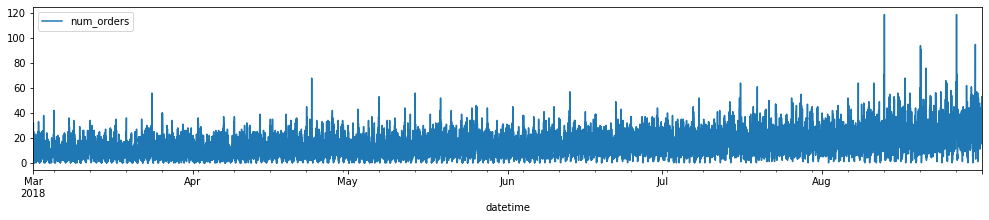

In [ ]:
data_all = data['2018-03-01':'2018-08-31']
data_all.plot(figsize=(17,3))

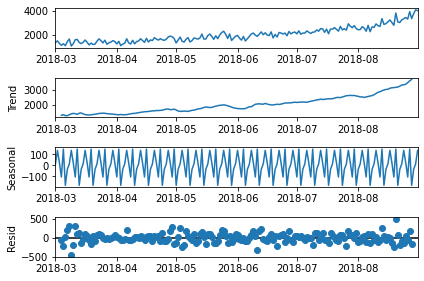

In [ ]:
data_1D = data.resample('1D').sum()
decomposed = seasonal_decompose(data_1D)
decomposed.plot();

Все 4 графика.

<AxesSubplot:xlabel='datetime'>

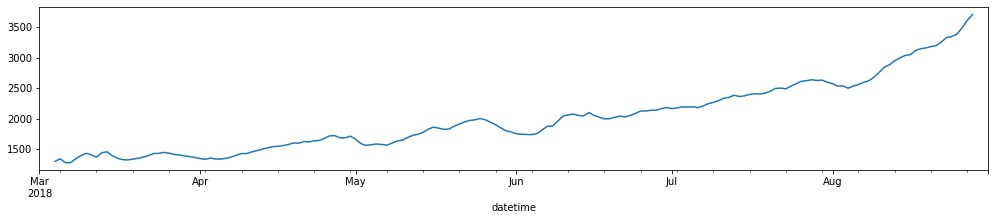

In [ ]:
decomposed.trend.plot(figsize=(17,3))

Тренд явно на увеличения.

<AxesSubplot:xlabel='datetime'>

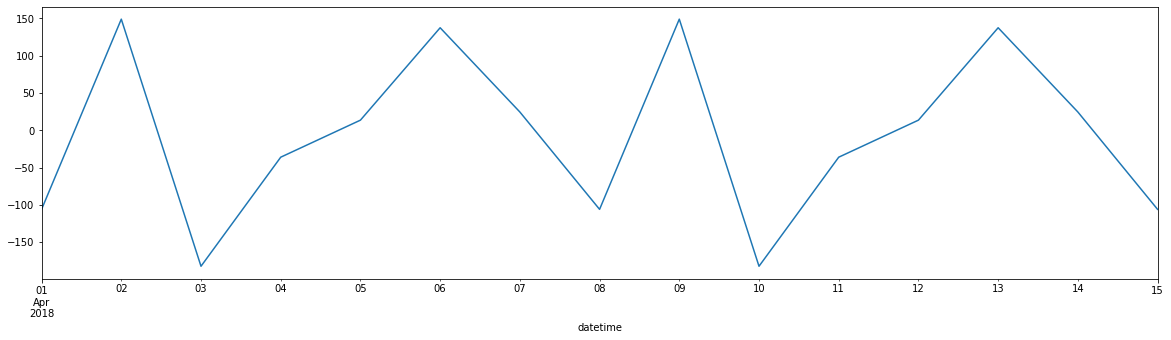

In [ ]:
decomposed.seasonal['2018-04-01':'2018-04-15'].plot(figsize=(20,5))

В конце недели заказов явно больше.

<AxesSubplot:xlabel='datetime'>

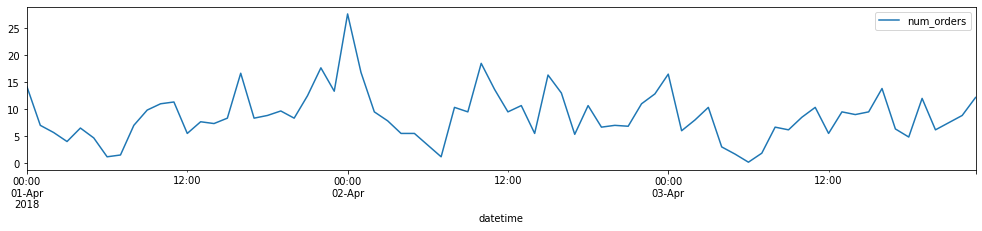

In [ ]:
one_hour = data['2018-04-01':'2018-04-03'].resample('60min').mean()
one_hour.plot(figsize=(17,3))

<AxesSubplot:xlabel='datetime'>

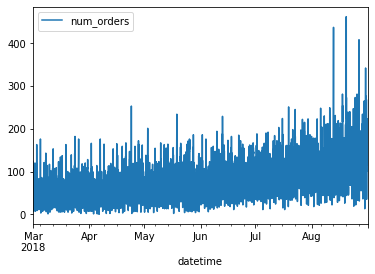

In [ ]:
data = data.resample('1h').sum()
data.plot()

In [ ]:
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


In [ ]:
def make_features(data, max_lag, rolling_mean_size):
    df = pd.DataFrame(data)
    df['year'] = data.index.year
    df['month'] = data.index.month
    df['day'] = data.index.day
    df['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    df = pd.DataFrame(data)
    return df

## Обучение

### LinearRegression

In [ ]:
df_line = make_features(data, 24,24)

In [ ]:
train_line, test_line = train_test_split(df_line, shuffle=False, test_size=0.1)
train_line = train_line.dropna()

In [ ]:
target_train_line = train_line['num_orders']
features_train_line = train_line.drop(['num_orders'] , axis=1)# < напишите код здесь ># < напишите код здесь >

features_test_line = test_line.drop(['num_orders'] , axis=1)
target_test_line = test_line['num_orders']

model_line = LinearRegression()

start = time.time()
model_line.fit(features_train_line, target_train_line)
end = time.time()
model_line_train_time = end - start

Лучшие параметры для линейной регресии, максимальный размер отставания и ширина окна для скользящей средней - 24.
это дает нам rmse 45,25

### DecisionTreeRegressor

In [ ]:
df = make_features(data, 24,24)

train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

target_train = train['num_orders']
features_train = train.drop(['num_orders'] , axis=1)

features_test = test.drop(['num_orders'] , axis=1)
target_test = test['num_orders']

splits = TimeSeriesSplit(n_splits=3)

In [ ]:
model_dt = DecisionTreeRegressor(random_state=12345)
parametrs = {"max_depth": [1,20]}
model_grid_dt = GridSearchCV(model_dt,parametrs,cv = splits,verbose=True,n_jobs=-1)

start = time.time()
model_grid_dt.fit(features_train,target_train)
end = time.time()
dt_train_time = end - start

Fitting 3 folds for each of 2 candidates, totalling 6 fits


### RandomForestRegressor

In [ ]:
model_rf = RandomForestRegressor(random_state=42)
parametrs = {"max_depth": [1,10],"n_estimators":[100,150,10]}
model_rf_grid = GridSearchCV(model_rf,parametrs,cv = splits,verbose=True,n_jobs=-1)

start = time.time()
model_rf_grid.fit(features_train,target_train)
end = time.time()
rf_train_time = end - start

Fitting 3 folds for each of 6 candidates, totalling 18 fits


### Catboost

In [ ]:
catboost = CatBoostRegressor(loss_function='RMSE',random_state = 12345)
parameters_cat = {'depth':[5,10], 'learning_rate':np.arange(0.1,1,0.2)}
catboost_grid = catboost.grid_search(parameters_cat,Pool(features_train,target_train),cv=splits,verbose=True)

0:	learn: 72.5761136	test: 106.6439346	best: 106.6439346 (0)	total: 5.19ms	remaining: 5.18s
1:	learn: 66.6188487	test: 99.9318587	best: 99.9318587 (1)	total: 9ms	remaining: 4.49s
2:	learn: 61.3838697	test: 93.5453615	best: 93.5453615 (2)	total: 12.5ms	remaining: 4.17s
3:	learn: 56.5416288	test: 87.4327597	best: 87.4327597 (3)	total: 15.8ms	remaining: 3.94s
4:	learn: 52.3016193	test: 82.5801851	best: 82.5801851 (4)	total: 19.1ms	remaining: 3.79s
5:	learn: 48.5055205	test: 78.0220041	best: 78.0220041 (5)	total: 22.4ms	remaining: 3.71s
6:	learn: 45.1747558	test: 74.2252480	best: 74.2252480 (6)	total: 25.6ms	remaining: 3.64s
7:	learn: 42.1321133	test: 70.3929398	best: 70.3929398 (7)	total: 29ms	remaining: 3.59s
8:	learn: 39.5017598	test: 67.3568304	best: 67.3568304 (8)	total: 32.2ms	remaining: 3.55s
9:	learn: 37.2222467	test: 64.4492216	best: 64.4492216 (9)	total: 35.6ms	remaining: 3.52s
10:	learn: 35.1983413	test: 61.4672727	best: 61.4672727 (10)	total: 38.9ms	remaining: 3.5s
11:	learn: 3

In [ ]:
final_cat = CatBoostRegressor(depth=catboost_grid["params"]["depth"],learning_rate=catboost_grid["params"]['learning_rate'],loss_function='RMSE',verbose=100)
start = time.time()
final_cat.fit(Pool(features_train,target_train))
end = time.time()
cb_train_time = end - start

0:	learn: 31.3018793	total: 4.32ms	remaining: 4.31s
100:	learn: 14.3715448	total: 366ms	remaining: 3.26s
200:	learn: 9.7524441	total: 731ms	remaining: 2.9s
300:	learn: 7.0751849	total: 1.1s	remaining: 2.55s
400:	learn: 5.0972529	total: 1.47s	remaining: 2.2s
500:	learn: 3.7724936	total: 1.82s	remaining: 1.82s
600:	learn: 2.8259956	total: 2.2s	remaining: 1.46s
700:	learn: 2.1207642	total: 2.58s	remaining: 1.1s
800:	learn: 1.5952755	total: 2.94s	remaining: 730ms
900:	learn: 1.2391134	total: 3.29s	remaining: 362ms
999:	learn: 0.9501639	total: 3.67s	remaining: 0us


<div class="alert alert-block alert-danger">
<b>Ошибка:</b> Не забудь про тестирование.
</div>


<div class="alert alert-block alert-info">
<b>Совет: </b> Финальные предсказания можно было визуализирвоать: графики исходного и предсказанных рядов.
</div>

## Тестирование

###  LinearRegression

In [ ]:
start = time.time()
predict_line = model_line.predict(features_test)
end = time.time()
print('Время обучения',model_line_train_time)
print('Время предсказания',end - start)
print("RMSE обучающей выборки:", mean_squared_error(target_test, predict_line)**0.5)

Время обучения 0.006524085998535156
Время предсказания 0.003190279006958008
RMSE обучающей выборки: 45.52933708020937


### DecisionTreeRegressor

In [ ]:
start = time.time()
model_dt_grid_predict = model_grid_dt.predict(features_test)
end = time.time()
print('Время обучения',dt_train_time)
print('Время предсказания',end - start)
print("RMSE обучающей выборки:", mean_squared_error(target_test, model_dt_grid_predict)**0.5)
print(model_grid_dt.best_params_)

Время обучения 0.1643826961517334
Время предсказания 0.0020012855529785156
RMSE обучающей выборки: 71.67310143108615
{'max_depth': 1}


### RandomForestRegressor

In [ ]:
start = time.time()
model_rf_grid_predict = model_rf_grid.predict(features_test)
end = time.time()
print('Время обучения',rf_train_time)
print('Время предсказания',end - start)
print("RMSE обучающей выборки:", mean_squared_error(target_test, model_rf_grid_predict)**0.5,)
print(model_rf_grid.best_params_)

Время обучения 22.262864112854004
Время предсказания 0.01941514015197754
RMSE обучающей выборки: 43.785397678925925
{'max_depth': 10, 'n_estimators': 150}


### Catboost

In [ ]:
start = time.time()
final_cat_predict = final_cat.predict(features_test)
end = time.time()
print('Время обучения',cb_train_time)
print('Время предсказания',end - start)
print("RMSE обучающей выборки:", mean_squared_error(target_test, final_cat_predict)**0.5,)

Время обучения 4.949077606201172
Время предсказания 0.004075527191162109
RMSE обучающей выборки: 44.818666490777794


<table class="iksweb">
	<tbody>
		<tr>
			<td>Модель</td>
			<td>Время предсказания</td>
			<td>Время обучения</td>
            <td>RMSE</td>
		</tr>
		<tr>
			<td>DecisionTreeRegressor</td>
			<td>0.002</td> 
			<td>0.26</td>
            <td>71.6</td>
		</tr>
        <tr>
			<td>RandomForestRegressor</td>
			<td>0.88</td>
			<td>29</td>
            <td>44.37</td>
		</tr>
        <tr>
			<td>Catboost</td>
			<td>0.002</td>
			<td>6.27</td>
            <td>44.01</td>
		</tr>
        <tr>
			<td>LinearRegression</td>
			<td>0.003</td>
			<td>0.006</td>
            <td>45.5</td>
		</tr>

## Вывод

Из таблицы видно что Catboost показал наилучшие результаты хотя разница между линейной регресиией совсем небольшая. Время обучения составило 6 сек в то время как линейная регрессия обучилась моментально.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [X]  Весь код выполняется без ошибок
- [X]  Ячейки с кодом расположены в порядке исполнения
- [X]  Данные загружены и подготовлены
- [X]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48